# **요약**

### Data Preprocessing
- Affine 변환
- Noramlization

### Model: CNN
- Padding
- Batch Normalization
- Drop Out
- Pooling
- Adam(optimizer)
- Cross Entropy Loss(Loss Function)

### Callback
- Learning Rate Scheduling
- Early Stopping
- Check Point(save best only)

### Pytorch Version
- 1.10.0+cu113

# **참고**
- Tensorflow 버전 : 'Private 3위, Public 점수: 0.95098, CNN model' https://dacon.io/competitions/official/235626/codeshare/1682?page=1&dtype=recent
- Pytorch Augmnetation : 마가리따님의 '파이토치 데이터 증강법 (점수:0.835)' https://dacon.io/competitions/official/235838/codeshare/3734?page=1&dtype=recent
- Pytorch Custom Dataset : 'Pytorch로 시작하는 딥러닝 입문' https://wikidocs.net/57165
- Pytorch CNN Modeling : 'Pytorch로 시작하는 딥러닝 입문' https://wikidocs.net/63565

# Import Library

In [1]:
import os
import warnings
from tqdm import tqdm
from glob import glob
from PIL import Image
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold

# Settings

In [2]:
#경고 무시
warnings.filterwarnings(action='ignore')

In [3]:
# torch version check
print('torch version: ', torch.__version__)

torch version:  1.10.0+cu113


In [4]:
# GPU 설정
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

device:  cuda:0


In [5]:
# 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)
else: torch.manual_seed(42)

# EDA

In [6]:
train = pd.read_csv('./dataset/train/train_data.csv')
test = pd.read_csv('./dataset/test/test_data.csv')

In [7]:
display(train, test)

,file_name,label
0,train0001.png,8
1,train0002.png,8
2,train0003.png,8
3,train0004.png,8
4,train0005.png,8
...,...,...
4995,train4996.png,6
4996,train4997.png,6
4997,train4998.png,6
4998,train4999.png,6


,file_name
0,idx0001.png
1,idx0002.png
2,idx0003.png
3,idx0004.png
4,idx0005.png
...,...
4995,idx4996.png
4996,idx4997.png
4997,idx4998.png
4998,idx4999.png


In [8]:
# train set label 분포 확인
train['label'].value_counts()

7    500
3    500
6    500
2    500
9    500
5    500
1    500
8    500
4    500
0    500
Name: label, dtype: int64

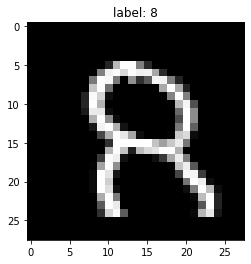

In [9]:
# 이미지 확인
sample_image = Image.open('./dataset/train/' + train['file_name'][0])
sample_label = train['label'][0]
plt.title('label: ' + str(sample_label))
plt.imshow(sample_image, cmap='gray')

# Data Preprocessing

In [10]:
def get_img_list(series, root_path) :
    # series : data['file_name']
    # root_path : 이미지 파일들이 존재하는 디렉토리 경로 ('./dataset/train/')
    # return : (28,28,1) 형태의 array들이 담긴 list
    
    reshaped_image_list = []

    for file_name in series :
        image_path = root_path + file_name
        image = Image.open(image_path)
        image_array = np.array(image)
        reshaped_image = image_array.reshape(28,28,1) #reshape
        reshaped_image_list.append(reshaped_image)
        
    return reshaped_image_list

In [11]:
def get_transform(mode='train'):
    # Data Augmentation
    # 마가리따님의 '파이토치 데이터 증강법 (점수:0.835)' 참고 : https://dacon.io/competitions/official/235838/codeshare/3734?page=1&dtype=recent
    
    t = list()
    t.append(transforms.ToTensor())
    
    if mode == 'train':
        t.append(transforms.RandomAffine(degrees=10, translate=(0.1,0.1)))

    t.append(transforms.Normalize(mean=(.5),std=(.5)))
    
    return transforms.Compose(t)

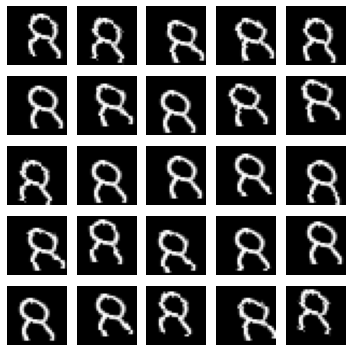

In [12]:
# Augmented Image 확인
sample_transform = get_transform()
sample_array = np.array(sample_image)

nrows, ncols = 5,5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        sample_augmented_image = sample_transform(sample_array).reshape(28,28)
        ax[i][j].imshow(sample_augmented_image, cmap='gray')
        ax[i][j].axis('off')

plt.tight_layout()
plt.show()

In [13]:
class CustomDataset(Dataset):
    def __init__(self, mode, img_list, label=None):
        self.mode = mode #train or test
        self.transform = get_transform(mode)
        self.img_list = img_list
        self.label = label # 정답값(train)
        self.transformed_img_list = list(map(self.transform, self.img_list))
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, i):
        
        x_data = self.transformed_img_list[i]

        if self.mode == 'train' :
            return {
              'X': x_data,
              'Y': torch.tensor(self.label[i], dtype=torch.long)
            }
        else :
            return {'X': x_data}

In [16]:
def get_dataloader(x, y, root_path, mode='train') :
    shuffle = True if mode == 'train' else False
    img_list = get_img_list(x, root_path)
    dataset = CustomDataset(mode=mode, img_list=img_list, label=y)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    total_batch = math.ceil(len(dataset)/batch_size)

    return dataloader, total_batch

# Modeling

In [14]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(batch_size, 28, 28, 2)
        #    Conv     -> (batch_size, 28, 28, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout(p=0.3))
        
        # 두번째층
        # ImgIn shape=(batch_size, 28, 28, 16)
        #    Conv      ->(batch_size, 28, 28, 32)
        #    Pool      ->(batch_size, 9, 9, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=3, stride=3),
            torch.nn.Dropout(p=0.3))
        
        # 세번째층
        # ImgIn shape=(batch_size, 9, 9, 32)
        #    Conv      ->(batch_size, 9, 9, 64)
        #    Pool      ->(batch_size, 3, 3, 64)        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=3, stride=3),
            torch.nn.Dropout(p=0.3))
        
        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(3*3*64, 10, bias=True)

        torch.nn.init.xavier_uniform_(self.fc.weight) # fc 가중치 초기화

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten
        out = self.fc(out)
        return out

In [15]:
class EarlyStopping:
    # 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', k_num=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.k_num = k_num

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{k_num}.pt')
        self.val_loss_min = val_loss

In [17]:
model = CNN().to(device)

In [18]:
root_path = os.getcwd() + '/dataset/train/'
batch_size = 64
epochs = 2000
learning_rate = 0.002
save_path = './weight'
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                    lr_lambda=lambda epoch: 0.95 ** epoch,
                                                    last_epoch=-1,
                                                    verbose=False)

# Model 학습

In [19]:
# Cross Validation

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
k_num = 0

for train_index, valid_index in skf.split(train['file_name'], train['label']) :
    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    k_num += 1
    early_stopping = EarlyStopping(patience = 300, verbose = True, path = save_path, k_num = k_num)
    
    x_train = train['file_name'][train_index].reset_index(drop=True)
    x_valid = train['file_name'][valid_index].reset_index(drop=True)
    y_train = train['label'][train_index].reset_index(drop=True)
    y_valid = train['label'][valid_index].reset_index(drop=True)

    train_dataloader, train_total_batch = get_dataloader(x_train, y_train, root_path, mode='train')
    valid_dataloader, valid_total_batch = get_dataloader(x_valid, y_valid, root_path, mode='train')
    
    for epoch in tqdm(range(epochs)) :
        train_avg_cost, valid_avg_cost = 0, 0

        for batch in train_dataloader :
            train_X = batch['X'].to(device)
            train_Y = batch['Y'].to(device)

            optimizer.zero_grad()
            hypothesis = model(train_X)
            cost = criterion(hypothesis, train_Y)
            cost.backward()
            optimizer.step()
            train_avg_cost += cost / train_total_batch

        scheduler.step()

        model.eval()
        for batch in valid_dataloader :
            valid_X = batch['X'].to(device)
            valid_Y = batch['Y'].to(device)

            with torch.no_grad() :
                hypothesis = model(valid_X)
                cost = criterion(hypothesis, valid_Y)
                valid_avg_cost += cost / valid_total_batch        

        early_stopping(float(valid_avg_cost), model)
        if early_stopping.early_stop:
            print("Early stopping!!")
            break            

  0%|          | 1/2000 [00:00<30:57,  1.08it/s]

Validation loss decreased (inf --> 0.313542).  Saving model ...


  0%|          | 2/2000 [00:01<29:07,  1.14it/s]

Validation loss decreased (0.313542 --> 0.205361).  Saving model ...


  0%|          | 3/2000 [00:02<30:35,  1.09it/s]

Validation loss decreased (0.205361 --> 0.136371).  Saving model ...


  0%|          | 4/2000 [00:03<30:38,  1.09it/s]

Validation loss decreased (0.136371 --> 0.081468).  Saving model ...


  0%|          | 5/2000 [00:04<31:17,  1.06it/s]

Validation loss decreased (0.081468 --> 0.078020).  Saving model ...


 15%|█▌        | 304/2000 [04:06<22:56,  1.23it/s]

Early stopping!!



  0%|          | 1/2000 [00:00<27:34,  1.21it/s]

Validation loss decreased (inf --> 0.279310).  Saving model ...


  0%|          | 2/2000 [00:01<27:11,  1.22it/s]

Validation loss decreased (0.279310 --> 0.134802).  Saving model ...


  0%|          | 3/2000 [00:02<27:34,  1.21it/s]

Validation loss decreased (0.134802 --> 0.118211).  Saving model ...


  0%|          | 6/2000 [00:04<26:56,  1.23it/s]

Validation loss decreased (0.118211 --> 0.095497).  Saving model ...


  0%|          | 7/2000 [00:05<26:31,  1.25it/s]

Validation loss decreased (0.095497 --> 0.091936).  Saving model ...


  0%|          | 8/2000 [00:06<27:11,  1.22it/s]

Validation loss decreased (0.091936 --> 0.075645).  Saving model ...


  1%|          | 17/2000 [00:13<27:55,  1.18it/s]

Validation loss decreased (0.075645 --> 0.072047).  Saving model ...


  1%|▏         | 26/2000 [00:21<26:43,  1.23it/s]

Validation loss decreased (0.072047 --> 0.070268).  Saving model ...


  2%|▏         | 43/2000 [00:34<26:29,  1.23it/s]

Validation loss decreased (0.070268 --> 0.066898).  Saving model ...


  2%|▏         | 44/2000 [00:35<26:21,  1.24it/s]

Validation loss decreased (0.066898 --> 0.056052).  Saving model ...


 17%|█▋        | 343/2000 [04:41<22:40,  1.22it/s]

Early stopping!!



  0%|          | 1/2000 [00:00<28:05,  1.19it/s]

Validation loss decreased (inf --> 0.273292).  Saving model ...


  0%|          | 2/2000 [00:01<27:25,  1.21it/s]

Validation loss decreased (0.273292 --> 0.185025).  Saving model ...


  0%|          | 3/2000 [00:02<30:25,  1.09it/s]

Validation loss decreased (0.185025 --> 0.146212).  Saving model ...


  0%|          | 4/2000 [00:03<30:08,  1.10it/s]

Validation loss decreased (0.146212 --> 0.118291).  Saving model ...


  0%|          | 9/2000 [00:08<30:48,  1.08it/s]

Validation loss decreased (0.118291 --> 0.107569).  Saving model ...


  1%|▏         | 27/2000 [00:22<26:21,  1.25it/s]

Validation loss decreased (0.107569 --> 0.102556).  Saving model ...


  1%|▏         | 28/2000 [00:23<26:44,  1.23it/s]

Validation loss decreased (0.102556 --> 0.097650).  Saving model ...


  2%|▏         | 30/2000 [00:25<26:38,  1.23it/s]

Validation loss decreased (0.097650 --> 0.096286).  Saving model ...


  2%|▏         | 31/2000 [00:26<26:34,  1.23it/s]

Validation loss decreased (0.096286 --> 0.096123).  Saving model ...


  2%|▏         | 34/2000 [00:28<26:45,  1.22it/s]

Validation loss decreased (0.096123 --> 0.095912).  Saving model ...


  2%|▏         | 36/2000 [00:30<26:38,  1.23it/s]

Validation loss decreased (0.095912 --> 0.095767).  Saving model ...


  2%|▏         | 38/2000 [00:31<26:24,  1.24it/s]

Validation loss decreased (0.095767 --> 0.095539).  Saving model ...


  2%|▏         | 40/2000 [00:33<27:14,  1.20it/s]

Validation loss decreased (0.095539 --> 0.095535).  Saving model ...


  2%|▏         | 43/2000 [00:36<27:28,  1.19it/s]

Validation loss decreased (0.095535 --> 0.095513).  Saving model ...


 17%|█▋        | 340/2000 [04:43<23:46,  1.16it/s]

Validation loss decreased (0.095513 --> 0.095212).  Saving model ...


 17%|█▋        | 341/2000 [04:43<23:41,  1.17it/s]

Validation loss decreased (0.095212 --> 0.094793).  Saving model ...


 17%|█▋        | 343/2000 [04:45<22:41,  1.22it/s]

Validation loss decreased (0.094793 --> 0.094471).  Saving model ...


 17%|█▋        | 346/2000 [04:48<23:19,  1.18it/s]

Validation loss decreased (0.094471 --> 0.094261).  Saving model ...


 17%|█▋        | 349/2000 [04:50<22:45,  1.21it/s]

Validation loss decreased (0.094261 --> 0.094120).  Saving model ...


 18%|█▊        | 351/2000 [04:52<22:59,  1.20it/s]

Validation loss decreased (0.094120 --> 0.093898).  Saving model ...


 32%|███▎      | 650/2000 [09:01<18:44,  1.20it/s]

Early stopping!!



  0%|          | 1/2000 [00:00<27:50,  1.20it/s]

Validation loss decreased (inf --> 0.290463).  Saving model ...


  0%|          | 2/2000 [00:01<27:03,  1.23it/s]

Validation loss decreased (0.290463 --> 0.153627).  Saving model ...


  0%|          | 4/2000 [00:03<27:16,  1.22it/s]

Validation loss decreased (0.153627 --> 0.067446).  Saving model ...


 15%|█▌        | 303/2000 [04:10<23:24,  1.21it/s]

Early stopping!!



  0%|          | 1/2000 [00:00<28:54,  1.15it/s]

Validation loss decreased (inf --> 0.267315).  Saving model ...


  0%|          | 2/2000 [00:01<28:27,  1.17it/s]

Validation loss decreased (0.267315 --> 0.257376).  Saving model ...


  0%|          | 3/2000 [00:02<28:26,  1.17it/s]

Validation loss decreased (0.257376 --> 0.145310).  Saving model ...


  0%|          | 4/2000 [00:03<29:30,  1.13it/s]

Validation loss decreased (0.145310 --> 0.139289).  Saving model ...


  0%|          | 5/2000 [00:04<29:54,  1.11it/s]

Validation loss decreased (0.139289 --> 0.137979).  Saving model ...


  0%|          | 6/2000 [00:05<29:27,  1.13it/s]

Validation loss decreased (0.137979 --> 0.109309).  Saving model ...


  1%|          | 11/2000 [00:09<27:45,  1.19it/s]

Validation loss decreased (0.109309 --> 0.094117).  Saving model ...


  1%|          | 15/2000 [00:12<27:09,  1.22it/s]

Validation loss decreased (0.094117 --> 0.087250).  Saving model ...


  1%|          | 19/2000 [00:15<27:14,  1.21it/s]

Validation loss decreased (0.087250 --> 0.074324).  Saving model ...


  1%|▏         | 25/2000 [00:21<27:33,  1.19it/s]

Validation loss decreased (0.074324 --> 0.074136).  Saving model ...


  1%|▏         | 29/2000 [00:24<29:16,  1.12it/s]

Validation loss decreased (0.074136 --> 0.072281).  Saving model ...


  2%|▏         | 32/2000 [00:27<27:26,  1.20it/s]

Validation loss decreased (0.072281 --> 0.071571).  Saving model ...


  2%|▏         | 34/2000 [00:28<27:34,  1.19it/s]

Validation loss decreased (0.071571 --> 0.071207).  Saving model ...


  2%|▏         | 37/2000 [00:31<26:30,  1.23it/s]

Validation loss decreased (0.071207 --> 0.070974).  Saving model ...


  2%|▏         | 38/2000 [00:31<26:46,  1.22it/s]

Validation loss decreased (0.070974 --> 0.070773).  Saving model ...


  2%|▏         | 40/2000 [00:33<26:31,  1.23it/s]

Validation loss decreased (0.070773 --> 0.070632).  Saving model ...


  2%|▏         | 44/2000 [00:36<27:36,  1.18it/s]

Validation loss decreased (0.070632 --> 0.070434).  Saving model ...


  2%|▏         | 45/2000 [00:37<27:35,  1.18it/s]

Validation loss decreased (0.070434 --> 0.070232).  Saving model ...


  2%|▏         | 46/2000 [00:38<28:10,  1.16it/s]

Validation loss decreased (0.070232 --> 0.070187).  Saving model ...


  2%|▏         | 49/2000 [00:41<27:08,  1.20it/s]

Validation loss decreased (0.070187 --> 0.070114).  Saving model ...


  3%|▎         | 55/2000 [00:46<28:24,  1.14it/s]

Validation loss decreased (0.070114 --> 0.069948).  Saving model ...


 18%|█▊        | 354/2000 [04:55<22:52,  1.20it/s]

Early stopping!!


# 추론

In [20]:
test_root_path = os.getcwd() + '/dataset/test/'
test_dataloader, test_total_batch = get_dataloader(test['file_name'], None, root_path=test_root_path, mode='test')

In [21]:
weigh_path_list = glob(save_path + '/*.pt')

preds = torch.tensor([[0]*10]*len(test), dtype=torch.float)

for weight in weigh_path_list :
    model.load_state_dict(torch.load(weight))
    model.eval()
    preds_n = []

    for batch in test_dataloader:
        X = batch['X'].to(device)
        with torch.no_grad():
            pred = model(X)
            preds_n += list(pred)
    
    for i in range(len(test)) :
        preds[i] += preds_n[i].cpu() 
        
preds = torch.argmax(preds, axis=-1)

In [23]:
preds

tensor([1, 0, 8,  ..., 3, 8, 0])

# 제출

In [24]:
sub = pd.read_csv('dataset/sample_submission.csv')

In [25]:
sub['label'] = preds

In [26]:
sub

,file_name,label
0,idx0001.png,1
1,idx0002.png,0
2,idx0003.png,8
3,idx0004.png,3
4,idx0005.png,5
...,...,...
4995,idx4996.png,9
4996,idx4997.png,9
4997,idx4998.png,3
4998,idx4999.png,8


In [27]:
sub.to_csv('자몽허니블랙티.csv', index=False)